## 실행(runs)을 비교하고, 모델을 선택하고, REST API에 배포
- 출처 : https://mlflow.org/docs/latest/getting-started/quickstart-2/index.html
- 수정사항 : 설명문을 한글로 번역 및 정상동작하도록 일부 코드 수정

MLflow Tracking 서버를 기동합니다.  
` mlfow server`

### 하이퍼파라미터 스윕(Hyperparameter Sweep) 실행
이 예에서는 와인 품질 데이터 세트에 대한 Keras 딥러닝 모델의 RMSE(Root Mean Squared Error) 메트릭을 최적화하려고 합니다.    
여기에서는 learning_rate와 momentum이라는 두 가지 하이퍼파라미터가 최적화하려고 합니다.   
Hyperopt 라이브러리를 사용하여 learning_rate와 momentum의 다양한 값에 대해 하이퍼파라미터 스윕을 실행하고 그 결과를 MLflow에 기록하겠습니다.
    
하이퍼파라미터 탐색을 실행하기 전에 MLFLOW_TRACKING_URI 환경 변수를 MLflow 추적 서버의 URI로 설정해 보겠습니다:

MLFLOW_TRACKING_URI 환경 변수를 MLflow Tracking 서버의 URI로 설정합니다.  
- Windows : `setx MLFLOW_TRACKING_URI="http://localhost:5000"  `
- macOS/Linux : `export MLFLOW_TRACKING_URI=http://localhost:5000 `



 파이썬의 머신러닝 모델 최적화를 위한 패키지 hyperopt를 설치합니다. 

In [43]:
%pip install -qU hyperopt

Note: you may need to restart the kernel to use updated packages.


패키지를 임포트합니다.

In [44]:
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import mlflow
from mlflow.models import infer_signature

이제 데이터 세트를 로드하고 학습, 유효성 검사 및 테스트 세트로 분할합니다.

In [45]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv",
    sep=";",
)

In [46]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [47]:
# Load dataset
data = pd.read_csv(
    "https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv",
    sep=";",
)

# Split the data into training, validation, and test sets
train, test = train_test_split(data, test_size=0.25, random_state=42)
train_x = train.drop(["quality"], axis=1).values
train_y = train[["quality"]].values.ravel()
test_x = test.drop(["quality"], axis=1).values
test_y = test[["quality"]].values.ravel()
train_x, valid_x, train_y, valid_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)
signature = infer_signature(train_x, train_y)

그런 다음 모델 아키텍처를 정의하고 모델을 훈련해 보겠습니다.   
train_model 함수는 MLflow를 사용하여 각 평가판의 매개 변수, 결과 및 모델 자체를 하위 실행으로 추적합니다.

In [48]:
def train_model(params, epochs, train_x, train_y, valid_x, valid_y):
    # Define model architecture
    model = keras.Sequential(
        [
            keras.Input([train_x.shape[1]]),
            keras.layers.Normalization(),
            # keras.layers.Normalization(mean=np.mean(train_x), variance=np.var(train_x)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(1),
        ]
    )

    # Compile model
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=params["lr"], momentum=params["momentum"]
        ),
        loss="mean_squared_error",
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    # Train model with MLflow tracking
    with mlflow.start_run(nested=True):
        model.fit(
            train_x,
            train_y,
            validation_data=(valid_x, valid_y),
            epochs=epochs,
            batch_size=64,
        )
        # Evaluate the model
        eval_result = model.evaluate(valid_x, valid_y, batch_size=64)
        eval_rmse = eval_result[1]

        # Log parameters and results
        mlflow.log_params(params)
        mlflow.log_metric("eval_rmse", eval_rmse)

        # Log model
        mlflow.tensorflow.log_model(model, "model", signature=signature)

        return {"loss": eval_rmse, "status": STATUS_OK, "model": model}

objective 함수는 하이퍼파라미터를 받아 해당 하이퍼파라미터 집합에 대한 train_model 함수의 결과를 반환합니다.

In [49]:
def objective(params):
    # MLflow will track the parameters and results for each run
    result = train_model(
        params,
        epochs=3,
        train_x=train_x,
        train_y=tf.cast(train_y, tf.float32),
        valid_x=valid_x,
        valid_y=tf.cast(valid_y, tf.float32)
    )
    return result

다음으로 Hyperopt의 search space를 정의하겠습니다.   
이 경우 학습 속도와 모멘텀의 다양한 값을 시도해 보겠습니다.  
Hyperopt는 일반적으로 무작위로 선택하거나 지정된 도메인 공간을 기반으로   
초기 하이퍼파라미터 세트를 선택하여 최적화 프로세스를 시작합니다.   
이 도메인 공간은 각 하이퍼파라미터에 대해 가능한 값의 범위와 분포를 정의합니다.  
초기 집합을 평가한 후 Hyperopt는 결과를 사용하여 확률 모델을 업데이트하고,   
후속 하이퍼파라미터 집합의 선택을 보다 정보에 입각한 방식으로 안내하여 최적의 솔루션으로 수렴하도록 합니다

In [50]:
space = {
    "lr": hp.loguniform("lr", np.log(1e-5), np.log(1e-1)),
    "momentum": hp.uniform("momentum", 0.0, 1.0),
}

마지막으로 objective function 와 search space을 전달하여 Hyperopt를 사용하여 하이퍼파라미터 스윕을 실행합니다.    
Hyperopt는 다양한 하이퍼파라미터 조합을 시도하고 가장 적합한 결과를 반환합니다.   
최적의 파라미터, 모델 및 평가 메트릭을 MLflow에 저장합니다.

In [52]:
mlflow.set_experiment("wine-quality")
with mlflow.start_run():
    # Conduct the hyperparameter search using Hyperopt
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=8,
        trials=trials,
    )

    # Fetch the details of the best run
    best_run = sorted(trials.results, key=lambda x: x["loss"])[0]

    # Log the best parameters, loss, and model
    mlflow.log_params(best)
    mlflow.log_metric("eval_rmse", best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"], "model", signature=signature)

    # Print out the best parameters and corresponding loss
    print(f"Best parameters: {best}")
    print(f"Best eval rmse: {best_run['loss']}")

2024/03/20 13:16:44 INFO mlflow.tracking.fluent: Experiment with name 'wine-quality' does not exist. Creating a new experiment.


Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 22s 492ms/step - loss: 1278.1741 - root_mean_squared_error: 35.7516
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: inf - root_mean_squared_error: inf             
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: inf - root_mean_squared_error: inf - val_loss: inf - val_root_mean_squared_error: inf

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: inf - root_mean_squared_error: inf
43/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: inf - root_mean_squared_error: inf 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: inf - root_mean_squared_error: inf - val_loss: 30518844180939572798947766959079424.0000 - val_root_mean_squared_error: 174696420375265280.0000

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - loss: 30518844180939572798947766959079424.0000 - root_mean_squared_error: 174696437555134464.0000
34/46 ━━━━━━

### 결과 비교  
웹브라우저에 MLFLOW_TRACKING_URI를 입력하여 MLflow UI를 엽니다.     

http://localhost:5000/

Experiments에서 wine-quality 를 클릭합니다.
Table view 보기에서 Columns 버튼을 선택하고 Metrics | eval_rmse 와 Parameters | lr 및 Parameters | momentum 을 선택합니다.   
RMSE 오름차순으로 정렬하려면 eval_rmse 열 헤더를 클릭합니다.   
eval_rmse 값이 가장 작은 값이 가장 좋은 실행입니다.    
가장 좋은 실행의 파라미터는 Parameters에서 확인할 수 있습니다.   
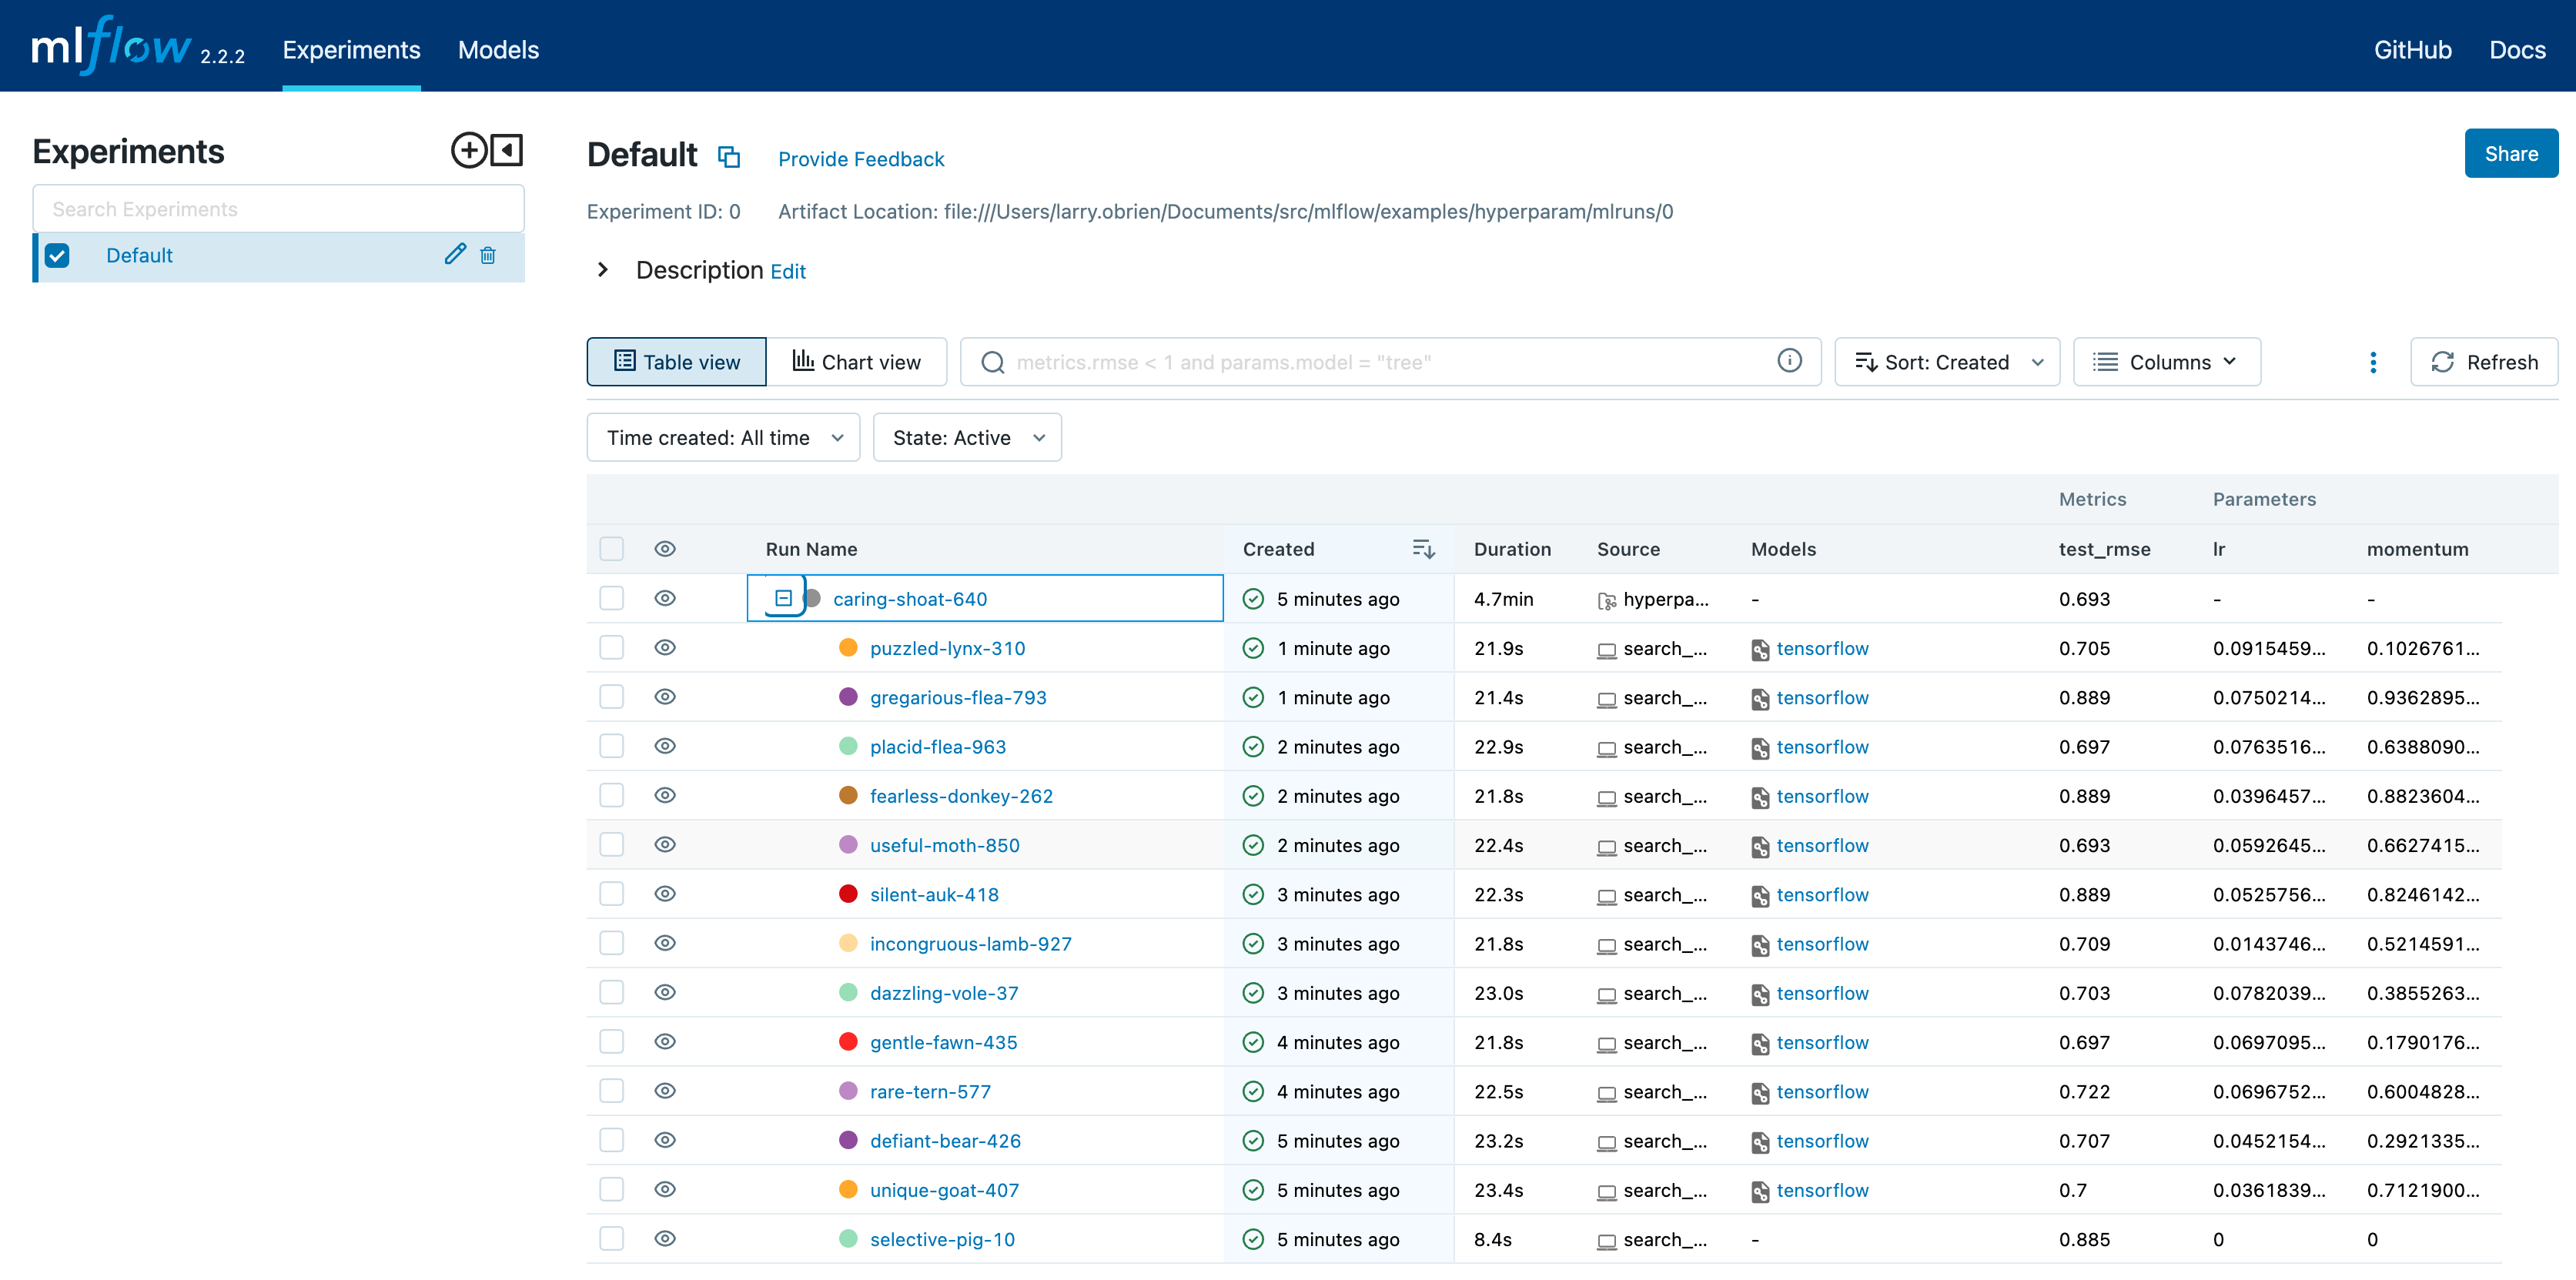

 Chart view를 선택하고, Add chart 버튼을 클릭합니다.
 Parallel coordinates 그래프를 선택하고 lr, momentum 파라미터와 eval_rmse 메트릭을 표시하도록 구성합니다.      
 이 그래프의 각 라인은 실행(runs)을 나타내며, 하이퍼파라미터와 메트릭을 연결합니다.    
 각 라인에 마우스를 가져가면 자세한 내용을 볼 수 있습니다.
 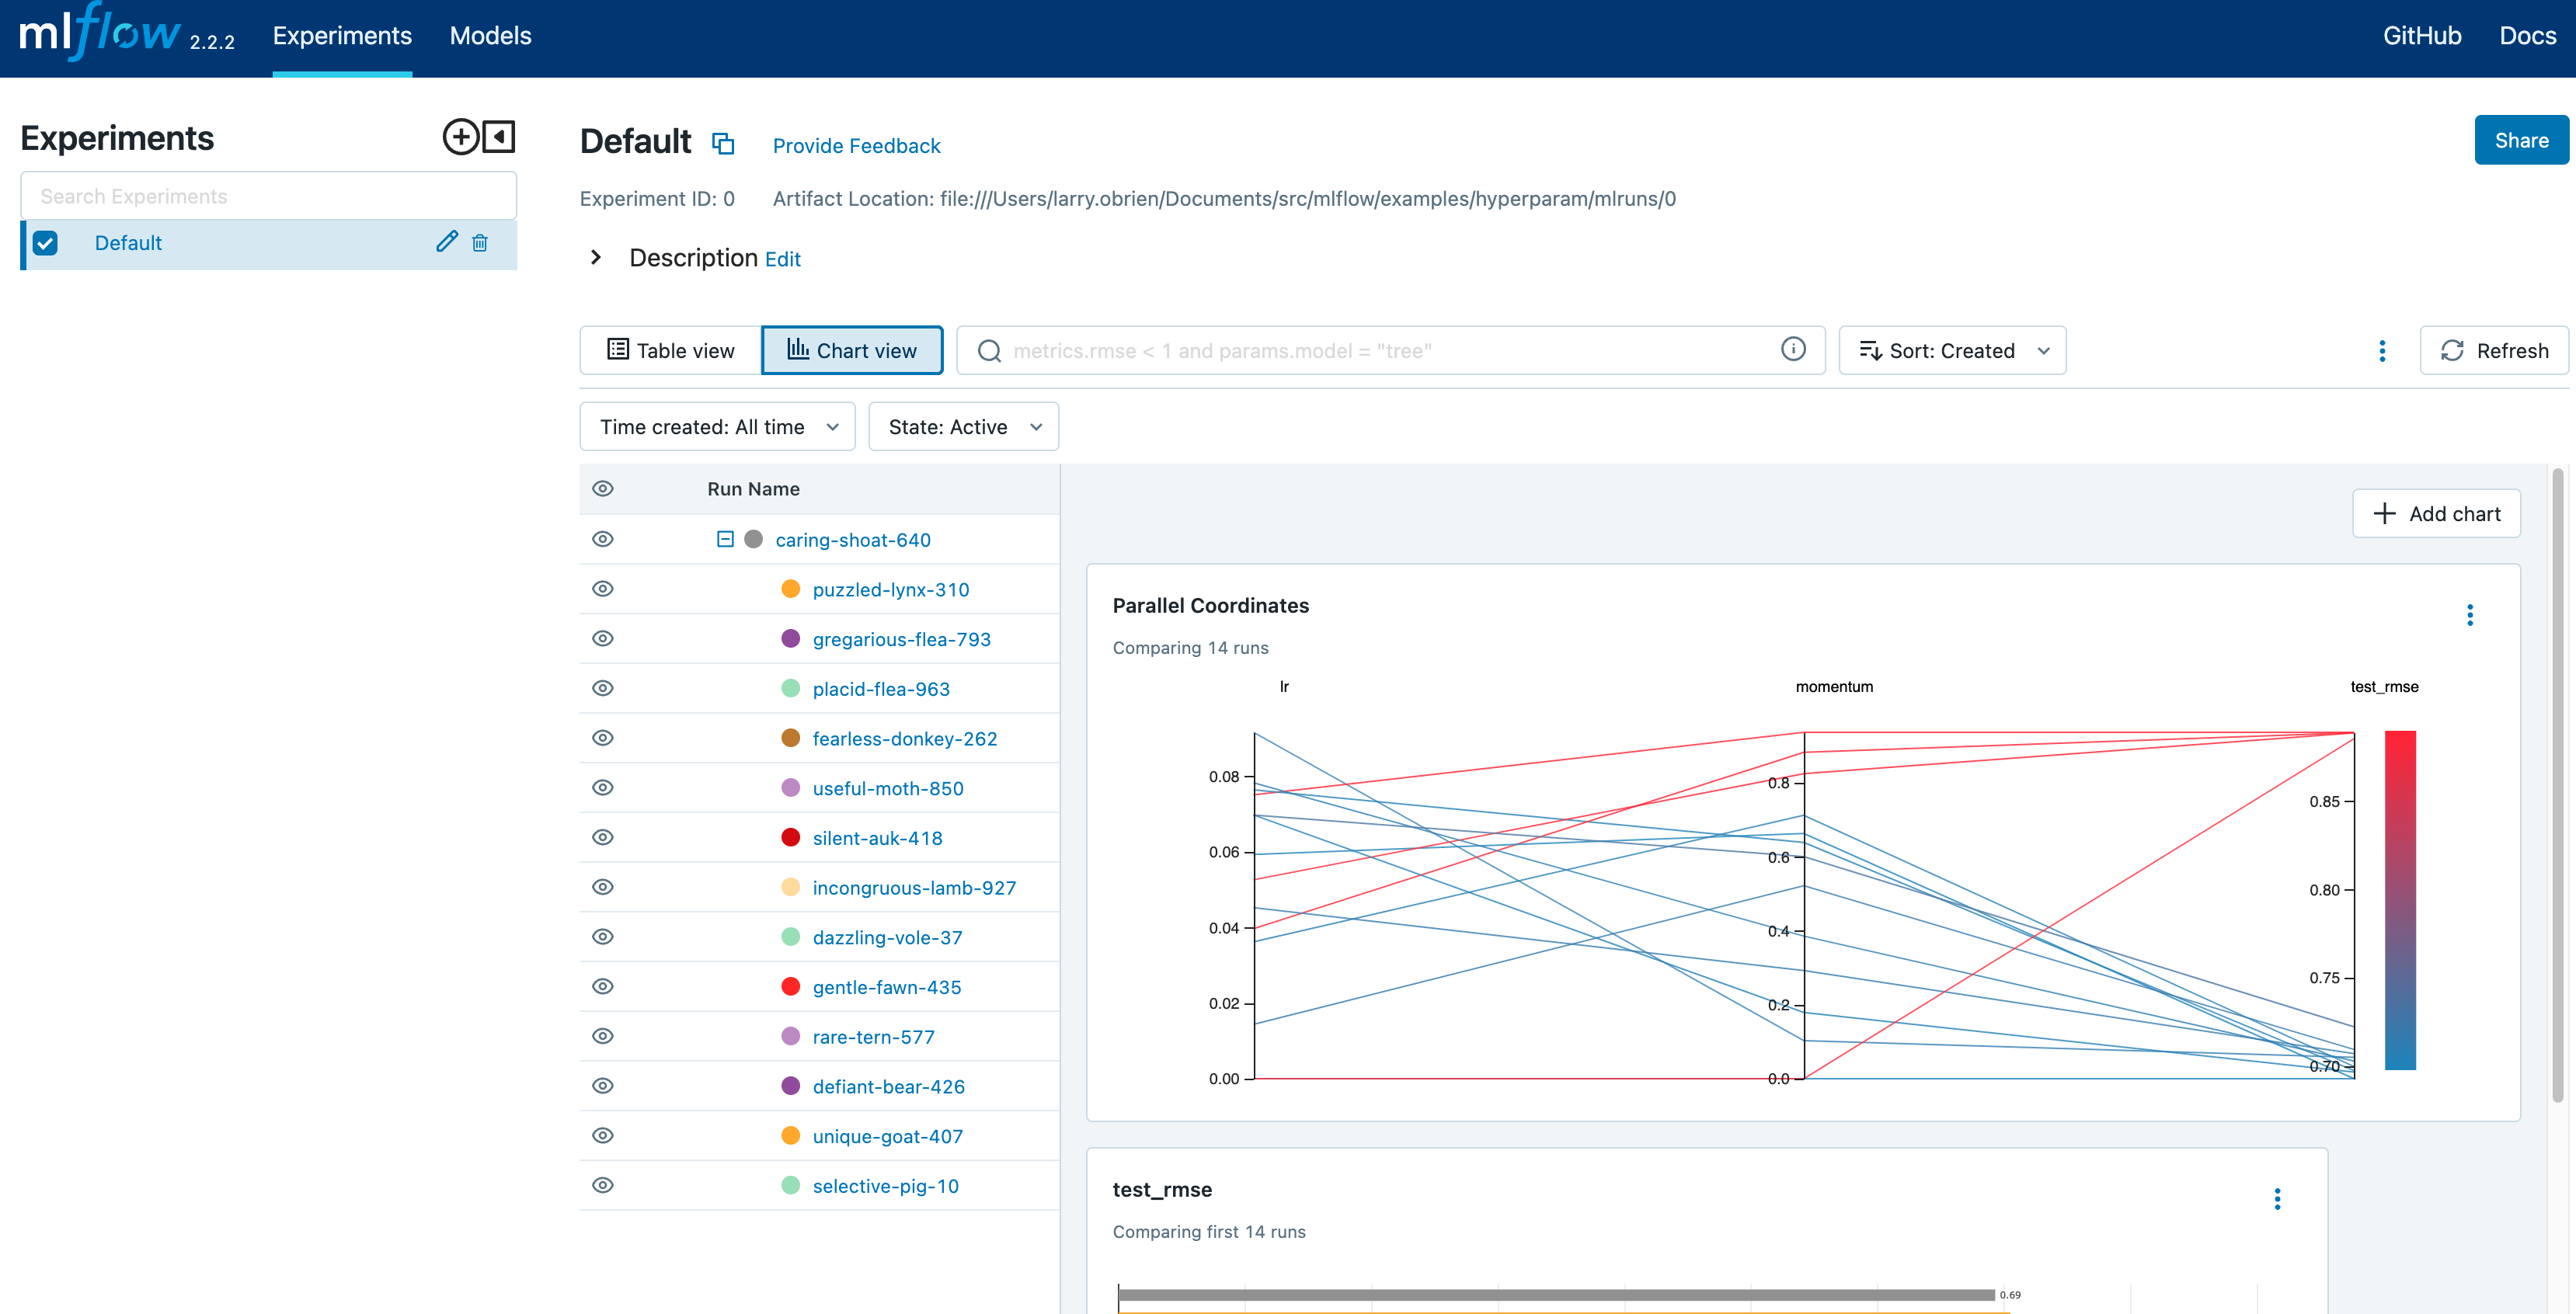

## Best model 등록하기
Table view에서 가장 좋은 실행을 클릭합니다.   
실행 세부 정보 페이지에서 Artifacts 섹션을 열고 Register model 버튼을 클릭합니다.   
Register Model 대화 상자에서 Create New Model을 선택합니다.   
Model Name 입력칸에 모델 이름(예: wine-quality)을 입력하고 Register을 클릭합니다.   
이제 모델을 배포할 수 있습니다. MLflow UI 상단 메뉴에 있는 Models 페이지에서 확인할 수 있습니다.     
방금 등록한 모델 이름을 클릭합니다.   
모델에 대한 Description을 추가하고, Tag를 추가합니다.   
Source Run 에서 run name을 클릭하여, 이 모델을 생성한 소스 실행으로 쉽게 돌아갈 수 있습니다.      
모델을 다른 단계로 전환할 수도 있습니다.   
예를 들어, 모델을 Staging 단계로 전환하여 테스트할 준비가 되었음을 나타낼 수 있습니다.   
Production 으로 전환하여 배포할 준비가 되었음을 나타낼 수 있습니다.   
Staging 드롭다운을 선택하여 모델을 Staging 단계로 전환합니다.(기존 UI에서 사용)

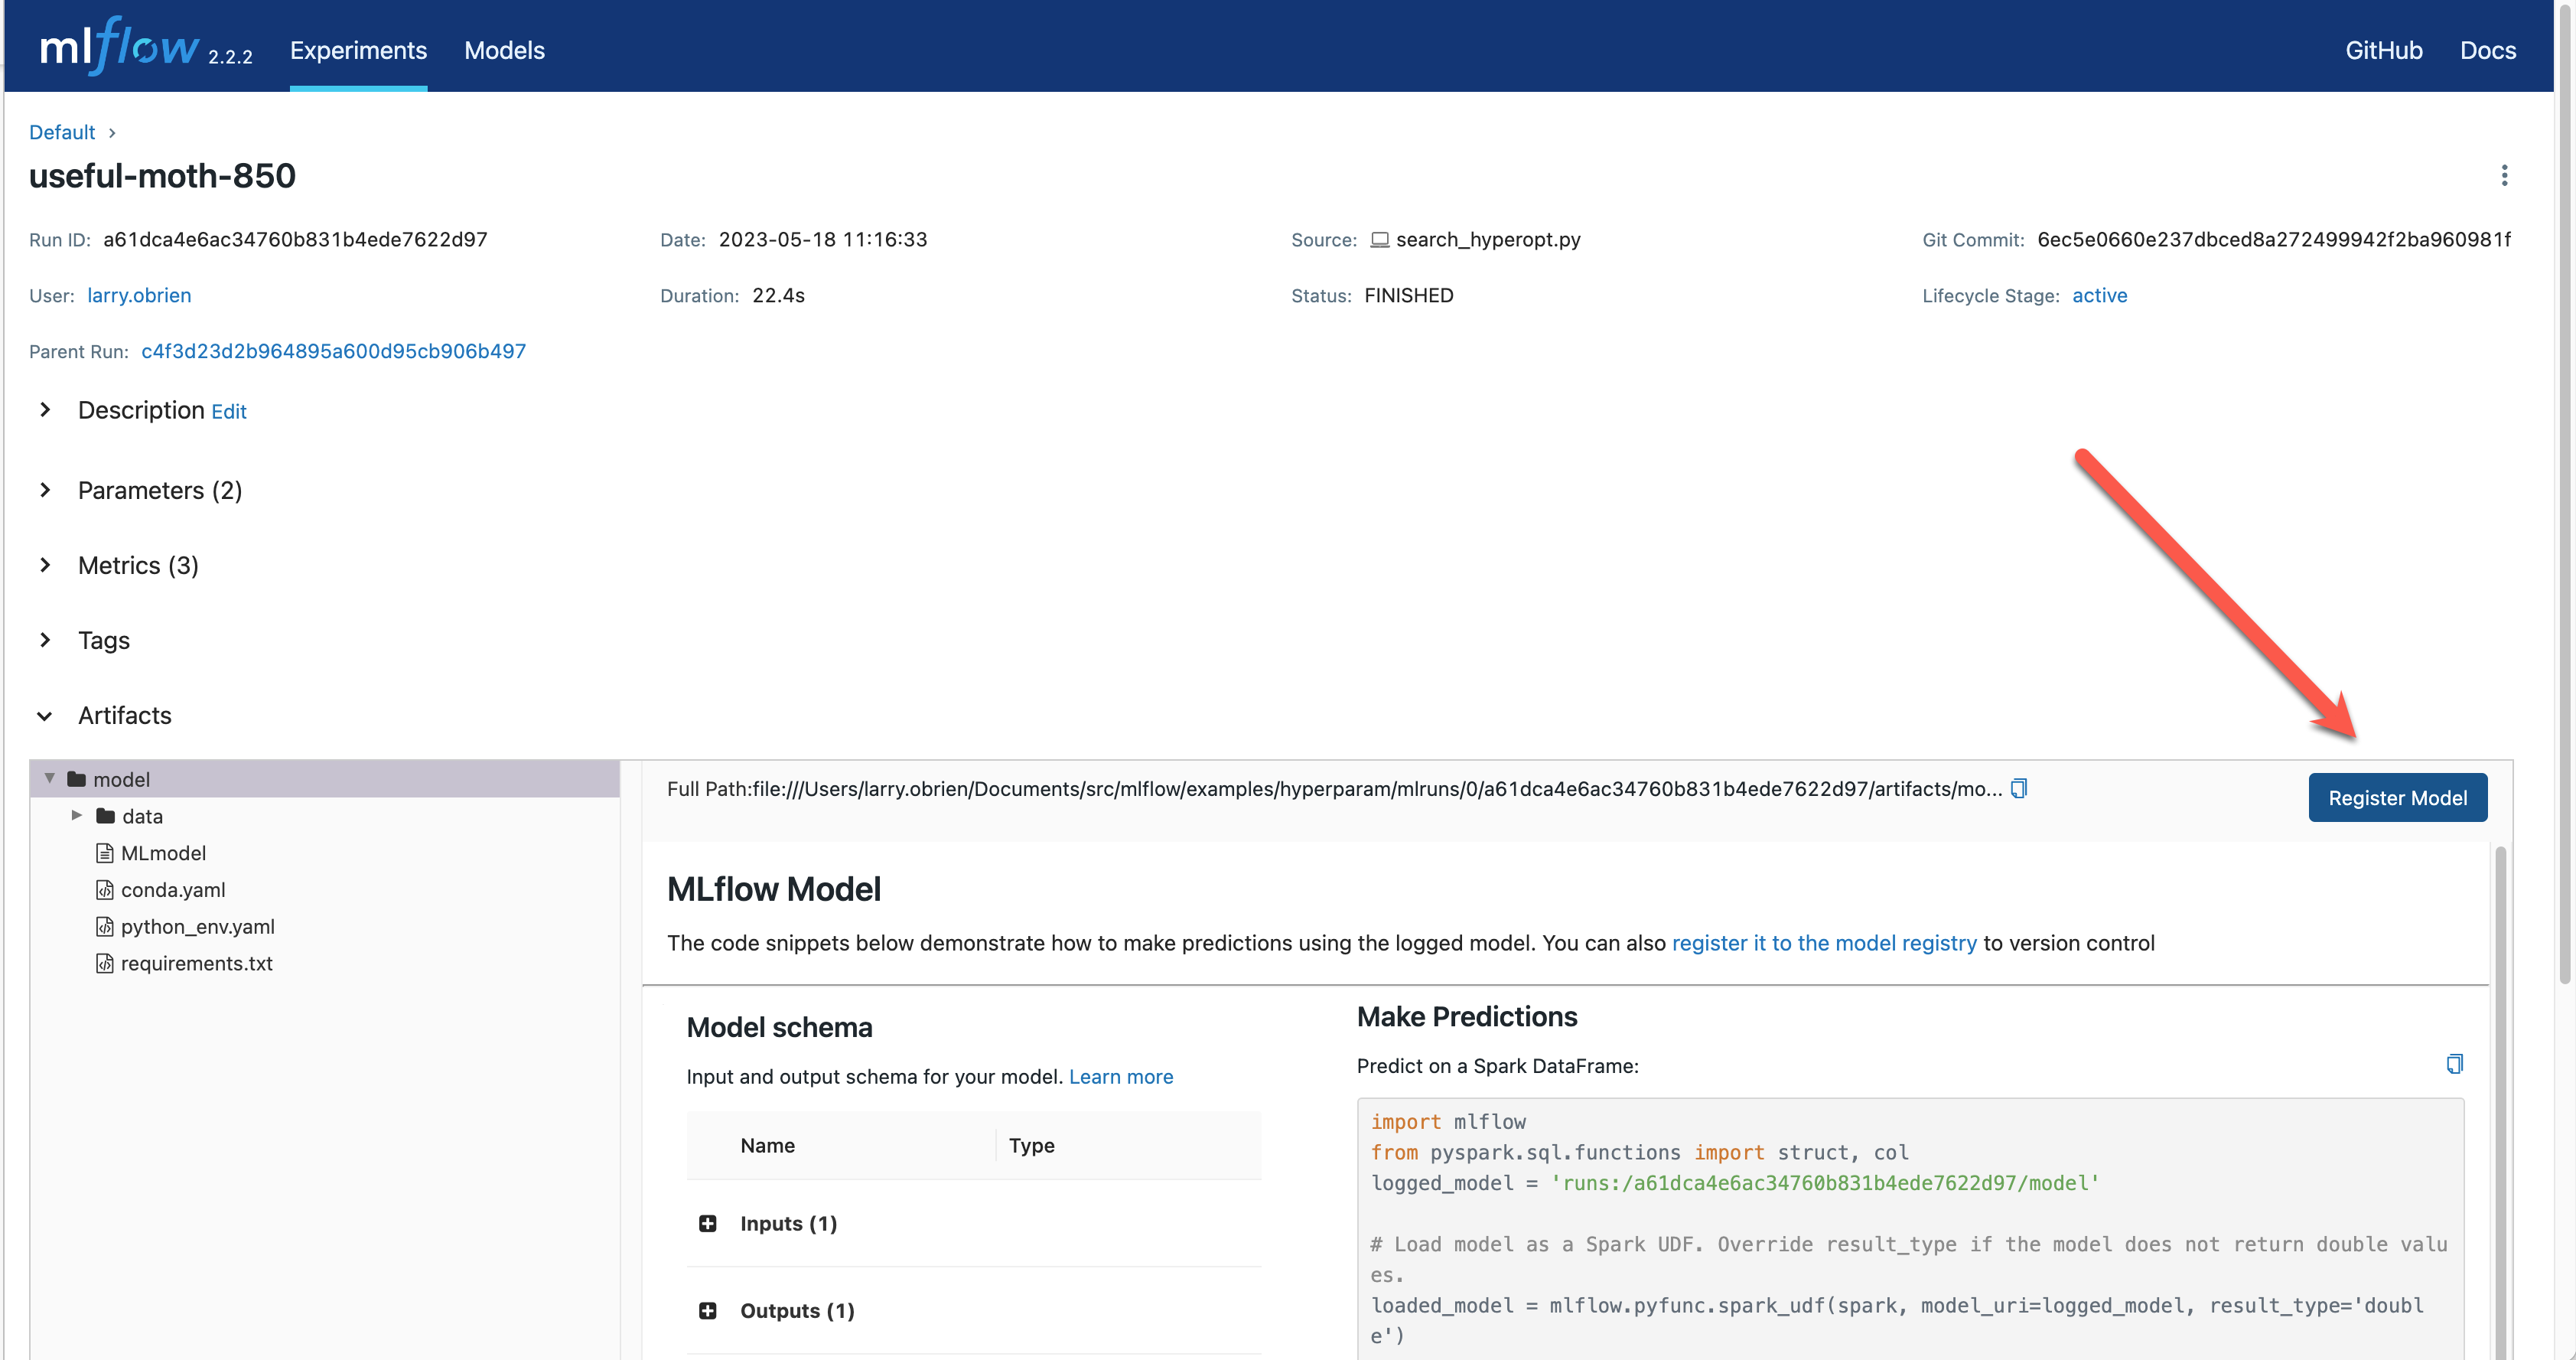


#### MLflow 2.9.0부터 Model Stages는 더 이상 사용되지 않으며 향후 주요 릴리스에서 제거될 예정입니다.    
MLOps 워크플로를 표현하기 위한 Model Stages 유연성을 높이기 위해, 모델 레지스트리에서 모델을 관리하고 배포하기 위한 새로운 도구가 도입 되었습니다.

- 참고 : https://www.mlflow.org/docs/latest/model-registry.html#migrating-from-stages   

## 로컬에서 모델 서빙
MLflow를 사용하면 모든 실행 또는 모델 버전에서 생성된 모델을 쉽게 제공할 수 있습니다.   
방금 등록한 모델을 실행하여 제공할 수 있습니다:  
`mlflow models serve -m "models:/wine-quality/1" --port 5002`
     
동일한 컴퓨터에서 기본 포트인 5000으로 Tracking 서버를 실행하는 경우 위와 같이 포트를 지정해야 합니다.    
모델을 서빙하기 위해 runs:/<run_id> URI를 사용하거나, Artifact Store어에 설명된 지원되는 URI를 사용할 수도 있습니다.   
프로덕션의 경우 리소스 제한으로 인해 추적 서버와 동일한 가상 머신에 모델을 배포하는 것은 권장하지 않으며, 
이 가이드에서는 단순화를 위해 동일한 머신에서 모든 것을 실행합니다.   
    
모델을 테스트하려면 curl 명령을 사용하여 REST API에 요청을 보낼 수 있습니다:

추론은 지정된 포트에서 localhost의 호출 경로에 대한 JSON POST 요청으로 수행됩니다.    
columns 키는 입력 데이터의 열 이름을 지정합니다.   
데이터 값은 목록의 목록이며, 각 내부 목록은 데이터 행입니다.    
간결성을 위해 위에서는 와인 품질에 대한 예측을 하나만 요청합니다(3~8점 척도).   
응답은 데이터 행마다 하나씩 예측 목록을 포함하는 예측 키가 있는 JSON 객체입니다.    
    
이 경우 응답은 다음과 같습니다:  
{"predictions": [{"0": 5.310967445373535}]}

입력 및 출력에 대한 스키마는 MLflow UI의 Artifacts  | Model  설명에서 사용할 수 있습니다.  
이 스키마는 train.py 스크립트가 mlflow.infer_signature 메서드를 사용하고   
그 결과를 mlflow.log_model 메서드로 전달했기 때문에 사용할 수 있습니다.   
로그 모델 메서드에 서명을 전달하면 입력 요청이 잘못된 경우 명확한 오류 메시지를 제공하므로 적극 권장됩니다.

### 모델에 대한 컨테이너 이미지 빌드
배포를 위한 대부분의 경로는 컨테이너를 사용하여 모델, 종속성 및 런타임 환경의 관련 부분을 패키징합니다.    
MLflow를 사용하여 모델에 대한 Docker 이미지를 빌드할 수 있습니다.  
`mlflow models build-docker --model-uri "models:/wine-quality/1" --name "qs_mlops" `

이 명령은 모델과 해당 종속성을 포함하는 qs_mlops라는 이름의 Docker 이미지를 빌드합니다.   
이 경우 model-uri는 수명 주기 단계(/staging)가 아닌 버전 번호(/1)를 지정하지만 워크플로와 가장 잘 통합되는 것을 사용할 수 있습니다.   
이미지를 빌드하는 데 몇 분 정도 걸립니다.   
이미지 구축이 완료되면 로컬, 온프레미스, 맞춤형 인터넷 서버 또는 클라우드 플랫폼에서 이미지를 실행하여 실시간 추론을 제공할 수 있습니다.   
로컬에서 실행할 수 있습니다:  
`docker run -p 5002:8080 qs_mlops  `

이 Docker 실행 명령은 방금 빌드한 이미지를 실행하고 로컬 머신의 포트 5002를 컨테이너의 포트 8080에 매핑합니다.   
이제 이전과 동일한 curl 명령을 사용하여 모델에 요청을 보낼 수 있습니다:

### 클라우드 플랫폼에 배포하기
거의 모든 클라우드 플랫폼에서 Docker 이미지를 배포할 수 있습니다.    
프로세스는 상당히 다양하므로 자세한 내용은 클라우드 제공업체의 설명서를 참조해야 합니다.  
또한 일부 클라우드 제공업체는 MLflow를 기본적으로 지원합니다. 
    
[Azure ML](https://learn.microsoft.com/ko-kr/azure/machine-learning/?view=azureml-api-2)
[Databricks](https://www.databricks.com/product/managed-mlflow)
[Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/)
[Google Cloud](https://cloud.google.com/docs?hl=ko)
   
모두 MLflow를 지원합니다. 
클라우드 플랫폼은 일반적으로 배포를 위해 명령줄, SDK 기반, 웹 기반 등 여러 워크플로를 지원합니다.   
세부 사항은 플랫폼과 버전에 따라 다르지만 이러한 워크플로 중 어느 워크플로에서나 MLflow를 사용할 수 있습니다.   
다시 말하지만 자세한 내용은 클라우드 제공업체의 설명서를 참조해야 합니다.